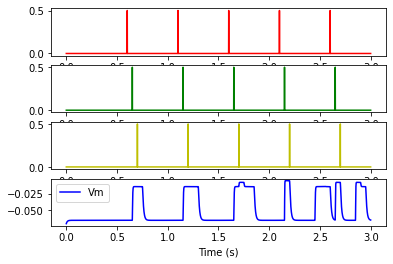

In [1]:
import sys
import os
import moose
import matplotlib.pyplot as plt
import numpy as np

#3 pulses are connected to 3 synapses. which pulse is connected to which synapse can be altered.

def setupmodel(modelpath, iaf_Rm, iaf_Cm, pulse_interval):
    model_container = moose.Neutral(modelpath)
    data_container = moose.Neutral(datapath)
    iaf = moose.LIF('%s/iaf' % (modelpath))
    iaf.Rm = iaf_Rm
    iaf.Cm = iaf_Cm
    iaf.initVm = -0.070
    iaf.Em = -0.065
    iaf.vReset = -0.070
    iaf.thresh = 1000000
    iaf.refractoryPeriod = 0.005

    syn = moose.SynChan('%s/syn' % (iaf.path))
    synh = moose.SeqSynHandler( syn.path + '/synh')
    
    
    for i in synh.vec:
        i.kernelEquation = "(x == t)*1"# + ((x+2)==t||(x-2)==t)*20 "
    synh.vec.kernelWidth = 3
    synh.vec.historyTime = 3
    synh.vec.sequenceScale = 0.00001
    synh.vec.plasticityScale = 0.0
    synh.vec.seqDt = 0.05
    v = synh.kernel 
    #print(v)

    moose.connect(synh, 'activationOut', syn, 'activation')



    synh.synapse.num = 3
    #for i in range(0,4):
    synh.synapse[0].delay = 0.01
        
        
    syn.Ek = 0.0
    syn.Gbar = 1.0
    moose.connect(syn, 'channel', iaf, 'channel')
    moose.connect(iaf, 'VmOut', syn, 'Vm')
    
    #first connection
    
    spike0 = moose.SpikeGen('%s/spike0' % (modelpath))
    spike0.threshold = 0.4
    

    
    pulse0 = moose.PulseGen('%s/pulse0' % (modelpath))
    pulse0.count = 10
    pulse_interval = 0.5
    pulse0.firstDelay = 0.1
    for i in range(1,10):
        pulse0.delay[i] = pulse_interval 
        pulse0.width[i] = 1e-3
        pulse0.level[i] = 0.5
    
    moose.connect(pulse0, 'output', spike0, 'Vm')
    

    moose.connect(spike0, 'spikeOut', synh.synapse[0], 'addSpike')
        
       
        
    #second connection
    
    spike1 = moose.SpikeGen('%s/spike1' % (modelpath))
    spike1.threshold = 0.4
    

    
    pulse1 = moose.PulseGen('%s/pulse1' % (modelpath))
    pulse1.count = 10
    pulse_interval = 0.5
    pulse1.firstDelay = 0.15
    for i in range(1,10):
        pulse1.delay[i] = pulse_interval 
        pulse1.width[i] = 1e-3
        pulse1.level[i] = 0.5

        
    moose.connect(pulse1, 'output', spike1, 'Vm')
    

    moose.connect(spike1, 'spikeOut', synh.synapse[1], 'addSpike')
    
    
     
    #third connection
    
    spike2 = moose.SpikeGen('%s/spike2' % (modelpath))
    spike2.threshold = 0.4
    

        
    pulse2 = moose.PulseGen('%s/pulse2' % (modelpath))
    pulse2.count = 10
    pulse_interval = 0.5
    pulse2.firstDelay = 0.2
    for i in range(1,10):
        pulse2.delay[i] = pulse_interval 
        pulse2.width[i] = 1e-3
        pulse2.level[i] = 0.5
    
        
    moose.connect(pulse2, 'output', spike2, 'Vm')
    

    moose.connect(spike2, 'spikeOut', synh.synapse[2], 'addSpike')
        
    
        
    return {
        'model': model_container,
        'iaf': iaf,
        'synchan': syn,
        'SeqSynHandler': synh,
        'spikegen0': spike0,
        'spikegen1': spike1,
        'spikegen2': spike2,
        'pulsegen0': pulse0,
        'pulsegen1': pulse1,
        'pulsegen2': pulse2
        }
   

if __name__ == '__main__':
    modelpath = '/lif_demo'
    datapath = '/data'
    simtime = 3
    setup = setupmodel(modelpath, 127e6, 7.8e-11, 0.5)
    
    # Setup data recording
    data_container = moose.Neutral(datapath)
    vm_table = moose.Table('%s/vm' % (data_container.path))
    
    moose.connect(vm_table, 'requestOut', setup['iaf'], 'getVm')
    spike0_table = moose.Table('%s/spike0' % (data_container.path))
    spike1_table = moose.Table('%s/spike1' % (data_container.path))
    spike2_table = moose.Table('%s/spike2' % (data_container.path))

    pulse0_table = moose.Table('%s/pulse0' % (data_container.path))
    pulse1_table = moose.Table('%s/pulse1' % (data_container.path))
    pulse2_table = moose.Table('%s/pulse2' % (data_container.path))
    
    
    moose.connect(pulse0_table, 'requestOut', setup['pulsegen0'], 'getOutputValue')
    moose.connect(pulse1_table, 'requestOut', setup['pulsegen1'], 'getOutputValue')
    moose.connect(pulse2_table, 'requestOut', setup['pulsegen2'], 'getOutputValue')
    #moose.connect(spike0_table, 'requestOut', setup['spikegen0'], 'getHasFired')
    
    #gsyn_table = moose.Table('%s/gk' % (datapath))
    #moose.connect(gsyn_table, 'requestOut', setup['synchan'], 'getIk')
    
    # Schedule model components for simulation
    moose.setClock(0, 1e-4)
    moose.setClock(1, 1e-4)
    moose.setClock(2, 1e-4)
    moose.setClock(3, 1e-4)
    moose.useClock(0, '%s,%s' % (setup['pulsegen0'].path, setup['spikegen0'].path), 'process')
    moose.useClock(0, '%s,%s' % (setup['pulsegen1'].path, setup['spikegen1'].path), 'process')
    moose.useClock(0, '%s,%s' % (setup['pulsegen2'].path, setup['spikegen2'].path), 'process')
    moose.useClock(1, setup['synchan'].path, 'process')
    moose.useClock(2, setup['iaf'].path, 'process')
    moose.useClock(3, '%s/##' % (datapath), 'process')
    
    #run simulation
    moose.reinit()
    moose.start(simtime)
    t = np.linspace(0, simtime, len(pulse0_table.vector))
    f,ax = plt.subplots(4,1)
    ax[0].plot(t, pulse0_table.vector, 'r', label='Input pulse0')
    ax[1].plot(t, pulse1_table.vector, 'g', label='Input pulse1')
    ax[2].plot(t, pulse2_table.vector, 'y', label='Input pulse2')
    ax[3].plot(t, vm_table.vector, 'b', label='Vm')
    
#     ax[4].plot(t, spike0_table.vector, 'r', label= "spike0")
#     ax[5].plot(t, spike1_table.vector, 'g', label = "spike1")
#     ax[6].plot(t, spike2_table.vector, 'y', label = "spike2")
    
    #plt.plot(t, pulse_table.vector, 'r', label='Input pulse')
    #plt.plot(t, vm_table.vector, 'b', label='Vm')
    #plt.plot(t, spike_table, 'r')
    #print(vm_table.vector)
   # plt.plot(t, gsyn_table.vector, 'c', label='Isyn')
    #print(pulse_table.vector)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.show()